In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv('./data/churn_train.csv')
test_df = pd.read_csv('./data/churn_test.csv')

# ● Analysera datan

In [3]:
train_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
test_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
train_df.duplicated().sum()

0

In [6]:
test_df.duplicated().sum()

0

In [7]:
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


# ● Förbered datan för att kunna användas av modellen

## ○ Finns det data som ej borde användas?

### Eftersom att customerID attributet inte spelar någon roll i hurvida en kund lämnar eller ej så kommer jag droppa den.

In [8]:
train_df = train_df.drop(columns='customerID')
test_df = test_df.drop(columns='customerID')

## ○ Det finns en hel del textdata som måste behandlas på något vis (finns flera olika alternativ, där vissa metoder är mer lämpade för neurala nätverk).

In [9]:
train_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### En observation efter att ha sett att TotalCharges är ett object men i datasetet verkar den innehålla floats precis som MonthlyCharges men att det är totalt vad kunden betalat i avgifter, när jag försökte göra om den till float så får jag error, jag skapar en funktion för att ta fram vad det är för värden och hur många som inte går att konvertera.

In [10]:
def can_convert(value):
    try:
        float(value)
        return True
    except:
        return False

In [11]:
train_unconvertable = []
for v in train_df['TotalCharges']:
    if can_convert(v) == False:
        train_unconvertable.append(v)

In [12]:
test_unconvertable = []
for v in test_df['TotalCharges']:
    if can_convert(v) == False:
        test_unconvertable.append(v)

In [13]:
print('Unconvertable in train set: ',train_unconvertable)
print('Count: ', len(train_unconvertable))

Unconvertable in train set:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Count:  8


In [14]:
print('Unconvertable in test set: ',test_unconvertable)
print('Count: ', len(test_unconvertable))

Unconvertable in test set:  [' ', ' ', ' ']
Count:  3


### Nu ser jag att samtliga värden som inte går att konvertera till float är tomma string rader, jag väljer att byta ut dom till 0 eftersom att det ska betyda att kunden inte blivit debiterad någonting ännu, och detta kommer bli bättre för min egna encoder senare. Men eftersom att jag gör så med träningsdatan så behöver jag även göra det med testdatan. Man ska ju inte ändra i testdatan utan låta den vara intakt, men jag känner att detta inte gör någon skillnad då en tom string är samma sak som att den hade varit 0.

In [15]:
train_df.loc[train_df['TotalCharges'] == ' ', 'TotalCharges'] = 0
test_df.loc[test_df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [16]:
train_df['TotalCharges'] = train_df['TotalCharges'].astype(float)
test_df['TotalCharges'] = test_df['TotalCharges'].astype(float)

### Eftersom att neurala nätverk gör matematiska beräkningar så är OneHotEncoding ett bättre alternativ.

In [17]:
x_train = train_df.drop(columns='Churn')
y_train = train_df['Churn']

x_test = test_df.drop(columns='Churn')
y_test = test_df['Churn']

In [18]:
def encode_columns(train_df,test_df):
    columns = train_df.columns
    # train_df_func = train_df.copy()
    # test_df_func = test_df.copy()
    colums_to_transform = []
    for c in columns:
        if train_df[c].dtype == 'object':
            colums_to_transform.append(c)
        elif c == 'SeniorCitizen':
            colums_to_transform.append(c)
        else:
            continue
    train_df_func = pd.get_dummies(train_df,columns=colums_to_transform,dtype=int)
    test_df_func = pd.get_dummies(test_df,columns=colums_to_transform,dtype=int)

    return train_df_func, test_df_func

In [19]:
encoded_x_train, encoded_x_test = encode_columns(x_train,x_test)

In [20]:
scaler = MinMaxScaler()

In [21]:
encoded_x_train = scaler.fit_transform(encoded_x_train)

In [22]:
encoded_x_test = scaler.transform(encoded_x_test)

In [23]:
encoded_x_test = pd.DataFrame(encoded_x_test,columns=scaler.feature_names_in_)

In [24]:
encoded_x_train = pd.DataFrame(encoded_x_train,columns=scaler.feature_names_in_)

# ● Träna 5 olika neurala nätverk och jämför tiden de tar att träna (låt resten av parametrarna vara default och använd samma random state för att få bättre jämförelse av tiden)

○ 4 gömda lager med 5 neuroner i varje, learning rate 0.01
○ 2 gömda lager med 100 neuroner, learning rate 0.01
○ 10 gömda lager med 100 neuroner i varje, learning rate 0.01
○ 2 gömda lager med 100 neuroner, learning rate 0.0001
○ 2 gömda lager med 100 neuroner, learning rate 0.00001
○ Utvärdera modellerna
■ Beräkna accuracy
■ Rita ut en confusion matrix och analysera hur modellen gör
prediktioner och vilka typer av fel den gör.

In [25]:
def predict_and_paint(model, y_test, x_test):
    predictions = model.predict(x_test)
    lab = y_test.unique()
    lab = sorted(lab)
    cm = confusion_matrix(y_test, predictions, labels=lab)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab)
    disp.plot()
    plt.show()

## ○ 4 gömda lager med 5 neuroner i varje, learning rate 0.01

In [26]:
# %%timeit
clf = MLPClassifier(hidden_layer_sizes=(5,5,5,5),learning_rate_init=0.01,random_state=42).fit(encoded_x_train,y_train)

### Träningen av denna tog 0.8s

In [27]:
clf.score(encoded_x_test,y_test)

0.7934705464868701

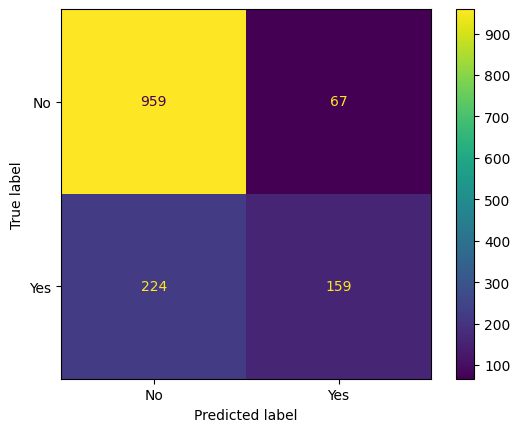

In [28]:
predict_and_paint(clf,y_test, encoded_x_test)

## ○ 2 gömda lager med 100 neuroner, learning rate 0.01

In [29]:
clf = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate_init=0.01,random_state=42).fit(encoded_x_train,y_train)

### Träningen av denna tog 9.3s

In [30]:
clf.score(encoded_x_test,y_test)

0.752306600425834

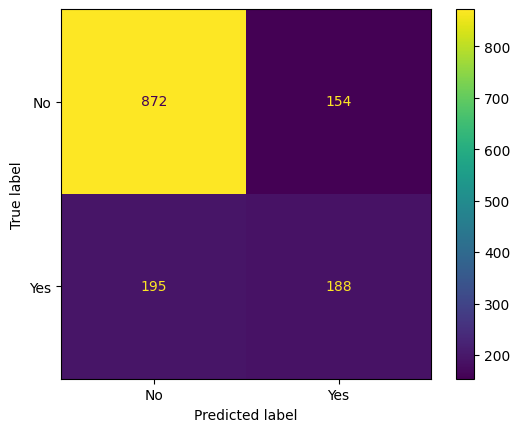

In [31]:
predict_and_paint(clf,y_test, encoded_x_test)

## ○ 10 gömda lager med 100 neuroner i varje, learning rate 0.01

In [32]:
clf = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100,100,100,100,100),learning_rate_init=0.01,random_state=42).fit(encoded_x_train,y_train)

### Träningen av denna tog 30.3s

In [33]:
clf.score(encoded_x_test,y_test)

0.772888573456352

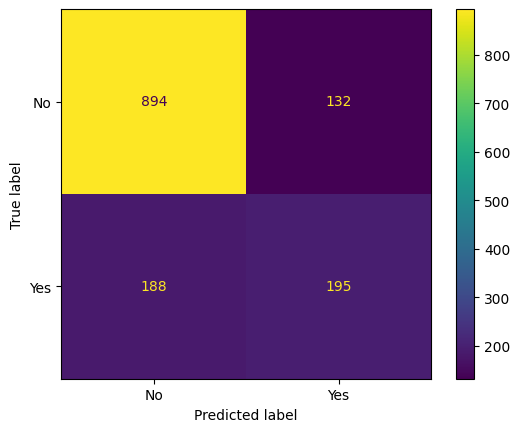

In [34]:
predict_and_paint(clf,y_test, encoded_x_test)

## ○ 2 gömda lager med 100 neuroner, learning rate 0.0001

In [35]:
clf = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate_init=0.0001,random_state=42).fit(encoded_x_train,y_train)

c:\Kodprojekt\MachineLearning\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Träningen av denna tog 14.8s, men detta efter att den har slutat tidigt pågrund utav maxiterationer.

In [36]:
clf.score(encoded_x_test,y_test)

0.7835344215755855

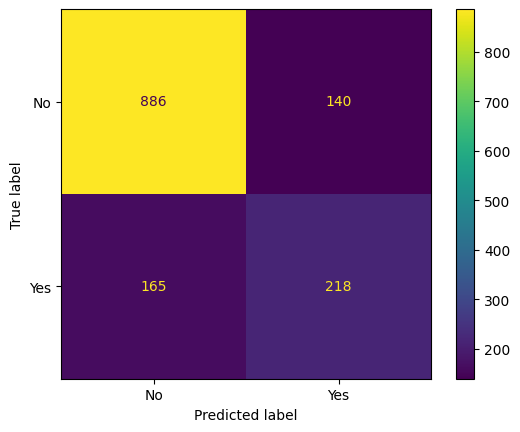

In [37]:
predict_and_paint(clf,y_test, encoded_x_test)

## ○ 2 gömda lager med 100 neuroner, learning rate 0.00001

In [38]:
clf = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate_init=0.00001,random_state=42).fit(encoded_x_train,y_train)

### Träningen av denna tog 15.3s.

In [39]:
clf.score(encoded_x_test,y_test)

0.7955997161107168

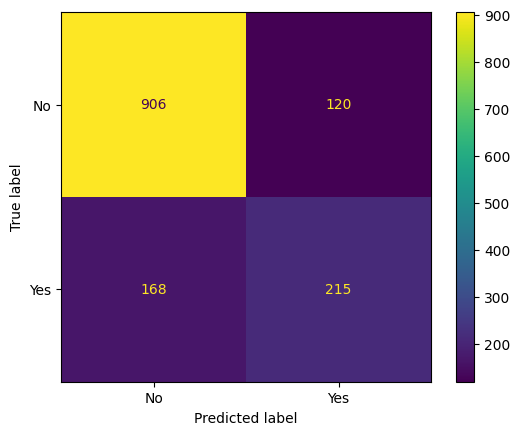

In [40]:
predict_and_paint(clf,y_test, encoded_x_test)

### Om man börjar med att försöka förklara tidsskillnaden det tar genom att se närmare på dom tre modeller som vi tränat som har två gömda lager och 100 neuroner i sig fast med olika learning_rate 0.01, 0.0001 och 0.00001 då dom har hidden_layer_sizes gemensamt så kan vi se att deras tider ökar med hur liten learning_raten är. Detta eftersom att modellen tar större steg när det är ett högre värde och därför så nöjer den sig snabbare, men sedan så blir ju inte tidsskillnaden mellan 0.0001, 0.00001 så stor och det är eftersom att den når sin maxgräns av iterationer konstigt nog enbart på den med 0.0001, om något så skulle jag trott att det var tvärtom eller att båda skulle ge upp tidigt men pågrund utav detta så verkar det som att dom kör ungefär lika länge men eftersom att då den med 0.0001 slutar tidigt men tar lika lång tid som den med 0,00001 så borde den senare av dom tagit ännu längre tid på sig om den inte hade varit nöjd tidigt.

### Om vi sedan går in på tidsskillnaden mellan dom två modeller som har 100st neuroner och 0.01 i learning_rate men en av dom har 2st gömda lager och den andra har 10st så ser vi att tiden ökar ju fler gömda lager vi har. Som vi ser så ökar det i vårt fall på nästan 10sekunder till 30 sekunder när man då går från 2 till 10 gömda lager.

### En intressant observation iom att jag använde MinMaxScaler är att om jag inte använder den utan jag kör datan som det är så får jag ungefär samma score för samtliga modeller men den får betydligt sämre prediktioner på dom som är klassade att lämna i dom första två modeller. Om man kollar då på skillnaden i parametrarna så har den färre neuroner och högre learning rate om man jämför med senare modeller, så det kan vara så att den inte hinner bli tränad tillräckligt länge för att göra bra prediktioner, kollar man på dens score som absolut är ganska högt så är ju detta för att största delen av datasetet består av 'yes' target som den verkar vilja klassificera för fulla muggar.

### Först delar vi upp original träningsdatan i validering och träningsdataset, eftersom att vi vill få fram opartiska bästa parametrar för modellen.

In [41]:
# x_train, x_validation, y_train, y_validation = train_test_split(encoded_x_train,y_train, test_size=0.3, random_state=42)

In [42]:
layer_size = [5,10,20,40,60,80,100]
layer_count = [2,4,6,8,10]
learning_rate_init = [0.001,0.0001,0.00001]
activation= ['logistic', 'tanh','relu']
learning_rate=['adaptive','constant','invscaling']

best_score = 0

layer_counts = []
import random
for x in range(10):
    for y in layer_count:
        layer = []
        for i in range(y):
            number = random.choice(layer_size)
            layer.append(number)
        layer_counts.append(layer)

print(layer_counts)

# for ls in layer_size:
for a in activation:
    for lr in learning_rate:
        for lc in layer_counts:
            for lri in learning_rate_init:
                clf = MLPClassifier(hidden_layer_sizes=lc,
                                    learning_rate_init=lri,
                                    learning_rate= lr,
                                    activation=a,
                                    max_iter=300,
                                    early_stopping=True,
                                    validation_fraction=0.3, 
                                    random_state=42
                                    ).fit(encoded_x_train,y_train)
                score = clf.best_validation_score_
                # score = clf.score(encoded_x_test,y_test)
                if score > best_score:
                    print(F'Layer_count: {lc}, Lerarning_rate_init: {lri},Learning_rate: {lr}, Activation: {a} Score: {score}')
                    best_score = score

[[10, 80], [20, 60, 5, 40], [60, 10, 80, 5, 60, 80], [5, 80, 40, 60, 10, 100, 100, 10], [80, 100, 60, 80, 40, 20, 20, 20, 100, 20], [100, 40], [20, 40, 60, 5], [80, 40, 5, 10, 10, 80], [20, 5, 100, 80, 40, 10, 40, 60], [20, 80, 5, 5, 5, 40, 20, 80, 60, 5], [20, 20], [60, 80, 40, 5], [40, 40, 100, 5, 40, 5], [5, 10, 80, 100, 10, 5, 80, 10], [5, 5, 80, 20, 100, 40, 80, 5, 80, 10], [40, 100], [20, 20, 100, 20], [60, 20, 80, 5, 80, 20], [80, 100, 10, 60, 40, 10, 20, 10], [10, 10, 100, 40, 100, 100, 80, 20, 20, 10], [5, 10], [60, 40, 40, 100], [10, 60, 40, 60, 10, 60], [60, 100, 20, 40, 5, 100, 100, 20], [60, 20, 100, 20, 20, 80, 5, 40, 10, 80], [80, 5], [100, 20, 20, 60], [80, 80, 100, 10, 60, 10], [5, 10, 60, 80, 10, 20, 5, 60], [5, 60, 10, 5, 100, 5, 10, 10, 20, 80], [100, 10], [100, 40, 80, 20], [10, 40, 100, 100, 40, 60], [20, 40, 20, 100, 5, 80, 5, 60], [40, 60, 100, 60, 5, 80, 5, 5, 40, 10], [10, 60], [40, 60, 40, 5], [100, 80, 40, 10, 60, 60], [60, 5, 40, 40, 5, 40, 20, 20], [10, 80

In [43]:
clf = MLPClassifier(hidden_layer_sizes=[60, 20, 80, 100],learning_rate_init=0.001,random_state=42, activation='relu',max_iter=300,early_stopping=True, learning_rate='adaptive').fit(encoded_x_train,y_train)

In [44]:
clf.score(encoded_x_test,y_test)

0.8097941802696949